<a href="https://colab.research.google.com/github/tylerscott3/CS290/blob/main/kmeansalgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [117]:
iris = load_iris()
df = pd.DataFrame( iris.data, columns = iris.feature_names)

In [118]:
data = load_iris()
X = data.data
y = data.target

In [119]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [120]:
df["species"] = iris.target

In [121]:
target_names = {
    0:'setosa',
    1:'versicolor',
    2:'virginica'
}

df['species_name'] = df['species'].map(target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


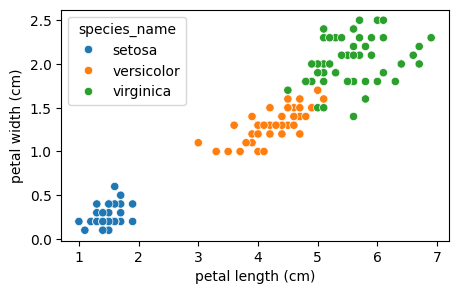

In [122]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");

In [123]:
centroids = df.groupby("species_name")[["petal length (cm)", "petal width (cm)"]].mean()

In [124]:
centroids

,petal length (cm),petal width (cm)
species_name,,
setosa,1.462,0.246
versicolor,4.260,1.326
virginica,5.552,2.026


In [125]:
centroids.loc["versicolor"]

,versicolor
petal length (cm),4.260
petal width (cm),1.326


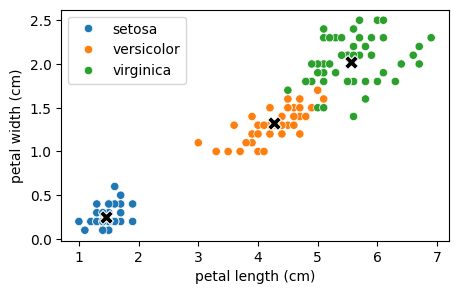

In [126]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name")
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = centroids, c = "black", marker="X", s = 100);

In [127]:
df = df.drop(columns=["species", "species_name"])

In [128]:

df[['current_cluster']] = -1
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,-1
146,6.3,2.5,5.0,1.9,-1
147,6.5,3.0,5.2,2.0,-1
148,6.2,3.4,5.4,2.3,-1


In [129]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [130]:
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

In [131]:
num_centroids = int(input("How many centroids?: "))
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

get_random_centroids(df, num_centroids)

How many centroids?: 4


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
149,5.9,3.0,5.1,1.8
49,5.0,3.3,1.4,0.2
143,6.8,3.2,5.9,2.3
9,4.9,3.1,1.5,0.1


In [132]:
def new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False
    return np.allclose(old_centroids.values, new_centroids.values, atol=1e-3)

In [133]:
def update_centroids(df):
    # Only calculate the mean for numeric columns, excluding 'species' or other non-numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()  # Get numeric columns
    numeric_cols.remove('current_cluster')  # Exclude the cluster assignment column
    return df.groupby("current_cluster")[numeric_cols].mean() # Only average selected cols

In [134]:
def plot_clusters(df, centroids, iters):
    plt.figure(figsize=(5, 3))

    # Plot each cluster
    sns.scatterplot(x = "petal length (cm)", y = "petal width (cm)", data = df);

    # Plot the centroids
    plt.scatter(
        centroids["petal length (cm)"], centroids["petal width (cm)"],
        color="red", marker="X", s=200, label="Centroids"
    )

    plt.title(f'Iteration {iters}')
    plt.xlabel("petal length (cm)")
    plt.ylabel("petal width (cm)")
    plt.legend()
    plt.show()
    plt.pause(1)
    clear_output(wait=True)

In [135]:
def get_cluster(df, centroids, plot=True):
    # initializes old centroids
    old_centroids = pd.DataFrame()
    # keep track of what # of iteration
    iteration = 0
    # run iteratively while the new centroids do not equal old ones
    while not new_centroids(old_centroids, centroids):
        # updates old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          plot_clusters(df, centroids, iteration)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df

In [136]:
get_random_centroids(df, num_centroids)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
90,5.5,2.6,4.4,1.2
132,6.4,2.8,5.6,2.2
40,5.0,3.5,1.3,0.3
135,7.7,3.0,6.1,2.3


In [137]:
get_cluster(df, get_random_centroids(df, num_centroids))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


In [138]:
def calculate_accuracy(df, clustered_df, target='species'):
    accuracy = 0
    for i in df.index:
        if df.loc[i, target] == clustered_df.loc[i, 'current_cluster']:
            accuracy += 1
    return accuracy / len(df)

In [139]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

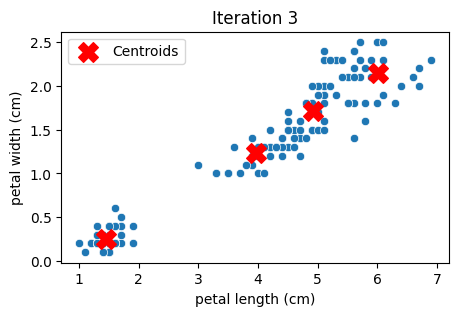

In [140]:
clustered_df = get_cluster(df, get_random_centroids(df, num_centroids))

In [141]:
inertia = get_inertia(clustered_df, update_centroids(clustered_df))
inertia


57.35088021295474

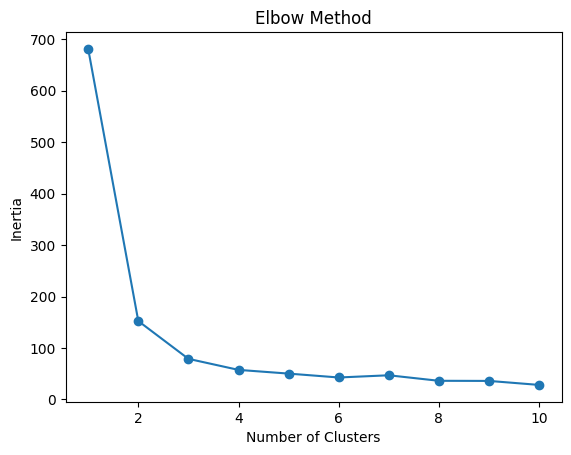

In [142]:
inertias = []
for i in range(1, 11):
    centroids = get_random_centroids(df, i)
    clustered_df = get_cluster(df, centroids, plot=False)
    inertia = get_inertia(clustered_df, update_centroids(clustered_df))
    inertias.append(inertia)


plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [143]:
def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):     # k is exclusive
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        # loop through each point in the data frame
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        # select new centroid
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])


In [144]:
get_cluster(df, initialize_centroids(df, num_centroids))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


In [145]:
def mean_cluster_distance(df, point_index):
    distances = []
    # get the current cluster of the point
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == current_cluster]
    # loop through all points in current cluster
    for i in cluster_points.index:
        # exclude the point itself
        if i != point_index:
            # calculate and append mean distance between the current point and all other points
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))

    return np.mean(distances) if distances else 0


In [146]:
def mean_closest_cluster_distance(df, point_index):
    total_distances = []
    # get the current cluster
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all other clusters
    other_clusters = df[df['current_cluster'] != current_cluster]
    # loop through each unique cluster in other_clusters
    for cluster in other_clusters['current_cluster'].unique():
        # get all points belonging to the cluster being considered
        cluster_points = df[df['current_cluster'] == cluster]
        # compute distance to all points in the current cluster
        distances = []
        for i in cluster_points.index:
            # calculate distance between this point and each point in the current cluster
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))
        # calculate mean distance to the current cluster
        total_distances.append(np.mean(distances))
    # return minimum mean distance among all clusters
    return min(total_distances)

In [147]:
def get_silhouette_coefficients(df):
    # get all points in the current cluster
    # df = df[df['current_cluster'] == cluster]
    # store coefficients for a cluster
    silhouette_coefficients = []
    # loop through each point in the cluster
    for i in df.index:
        # calculate mean inter cluster distance
        a = mean_cluster_distance(df, i)
        # calculate mean nearest cluster distance
        b = mean_closest_cluster_distance(df, i)
        # compute silhouette coefficient for each point
        silhouette_coefficients.append((b - a) / max(a, b))
    # return silhouette coefficients for all points in the cluster
    return silhouette_coefficients



In [148]:
def assign_silhouette_to_clusters(df, silhouette_scores):
    # Add a column for silhouette scores
    df['silhouette_score'] = silhouette_scores
    return df

In [149]:
sil_score = get_silhouette_coefficients(df)

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store silhouette scores for different k values
silhouette_scores = []

# Iterate over different values of k (number of clusters)
for k in range(2, 7):  # Example range, adjust as needed
    centroids = initialize_centroids(df, k)
    clustered_df = get_cluster(df, centroids, plot=False)

    # List to store silhouette coefficients for all points
    sil_coefficients_all_clusters = []

    # Loop through each unique cluster and calculate silhouette coefficients
    for cluster in clustered_df['current_cluster'].unique():
        cluster_points = clustered_df[clustered_df['current_cluster'] == cluster]

        # Get silhouette coefficients for the entire cluster group
        sil_coefficients = get_silhouette_coefficients(clustered_df['current_cluster'])  # Assuming you need the whole dataframe
        sil_coefficients_all_clusters.extend(sil_coefficients)

    # Calculate the mean silhouette score for this k
    sil_score = np.mean(sil_coefficients_all_clusters)
    silhouette_scores.append(sil_score)

# Plot the silhouette score for each k
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


IndexingError: Too many indexers